In [18]:
'''Train CIFAR10 with PyTorch.'''
!pip install torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
!pip install torchvision
import torchvision
import torchvision.transforms as transforms
!pip install os
import os
!pip install argparse
import argparse
!pip install torchinfo
from torchinfo import summary
# from models import *
# from utils import progress_bar

ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os
  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


In [19]:
# !cp drive/MyDrive/utils.py .
# !cp drive/MyDrive/ResNet.py .

In [20]:
# parser = argparse.ArgumentParser(description='PyTorch CIFAR10 Training')
# parser.add_argument('--lr', default=0.1, type=float, help='learning rate')
# parser.add_argument('--resume', '-r', action='store_true',
#                     help='resume from checkpoint')
# args = parser.parse_args()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

In [21]:
# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.3, hue=0.3),
    #transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
    #transforms.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75)),
    #transforms.GaussianBlur(3, sigma=(0.1, 2.0)),  # augmentation
    
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

==> Preparing data..


In [22]:
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2) #128

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2) #100

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


In [23]:
print(len(trainloader))

391


In [24]:
# Model
print('==> Building model..')


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



==> Building model..


In [25]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


In [26]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        #self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(1024*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        #out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


In [27]:
net = ResNet(BasicBlock, [2, 2, 2, 2])

print(summary(net,input_size=(128,3,32,32)))#input_size = (batch_size, #channel,imgsize)
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [128, 10]                 --
├─Conv2d: 1-1                            [128, 64, 32, 32]         1,728
├─BatchNorm2d: 1-2                       [128, 64, 32, 32]         128
├─Sequential: 1-3                        [128, 64, 32, 32]         --
│    └─BasicBlock: 2-1                   [128, 64, 32, 32]         --
│    │    └─Conv2d: 3-1                  [128, 64, 32, 32]         36,864
│    │    └─BatchNorm2d: 3-2             [128, 64, 32, 32]         128
│    │    └─Conv2d: 3-3                  [128, 64, 32, 32]         36,864
│    │    └─BatchNorm2d: 3-4             [128, 64, 32, 32]         128
│    │    └─Sequential: 3-5              [128, 64, 32, 32]         --
│    └─BasicBlock: 2-2                   [128, 64, 32, 32]         --
│    │    └─Conv2d: 3-6                  [128, 64, 32, 32]         36,864
│    │    └─BatchNorm2d: 3-7             [128, 64, 32, 32]         

In [28]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001,
                      #momentum=0.9, weight_decay=6e-4)
optimizer = optim.Adam(net.parameters(),lr = 1e-3, weight_decay=6e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [29]:
# Training
tracc_list = []
trloss_list = []

def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()


        print('Train Epoch: %d | Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (epoch, train_loss/(batch_idx+1), 100.*correct/total, correct, total))

        # progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
        #              % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    tracc_list.append(100.*correct/total)
    trloss_list.append(train_loss/(batch_idx+1))

In [30]:
tacc_list = []
tloss_list = []

def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()


            print('Test Epoch: %d | Loss: %.3f | Acc: %.3f%% (%d/%d)'
                  % (epoch, test_loss/(batch_idx+1), 100.*correct/total, correct, total))
            # progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            #              % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
        tacc_list.append(100.*correct/total)
        tloss_list.append(test_loss/(batch_idx+1))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc

In [ ]:
for epoch in range(start_epoch, start_epoch+100):
    train(epoch)
    test(epoch)
    scheduler.step()


Epoch: 0
Train Epoch: 0 | Loss: 2.543 | Acc: 8.594% (11/128)
Train Epoch: 0 | Loss: 2.946 | Acc: 12.500% (32/256)
Train Epoch: 0 | Loss: 3.013 | Acc: 11.458% (44/384)
Train Epoch: 0 | Loss: 2.908 | Acc: 12.500% (64/512)
Train Epoch: 0 | Loss: 2.825 | Acc: 12.500% (80/640)
Train Epoch: 0 | Loss: 2.788 | Acc: 12.630% (97/768)
Train Epoch: 0 | Loss: 2.726 | Acc: 13.616% (122/896)
Train Epoch: 0 | Loss: 2.693 | Acc: 13.574% (139/1024)
Train Epoch: 0 | Loss: 2.647 | Acc: 14.323% (165/1152)
Train Epoch: 0 | Loss: 2.626 | Acc: 14.688% (188/1280)
Train Epoch: 0 | Loss: 2.597 | Acc: 14.702% (207/1408)
Train Epoch: 0 | Loss: 2.568 | Acc: 14.714% (226/1536)
Train Epoch: 0 | Loss: 2.541 | Acc: 15.084% (251/1664)
Train Epoch: 0 | Loss: 2.519 | Acc: 15.402% (276/1792)
Train Epoch: 0 | Loss: 2.498 | Acc: 15.625% (300/1920)
Train Epoch: 0 | Loss: 2.480 | Acc: 15.576% (319/2048)
Train Epoch: 0 | Loss: 2.462 | Acc: 15.993% (348/2176)
Train Epoch: 0 | Loss: 2.451 | Acc: 15.799% (364/2304)
Train Epoch: 0

In [34]:
print(best_acc)

90.61


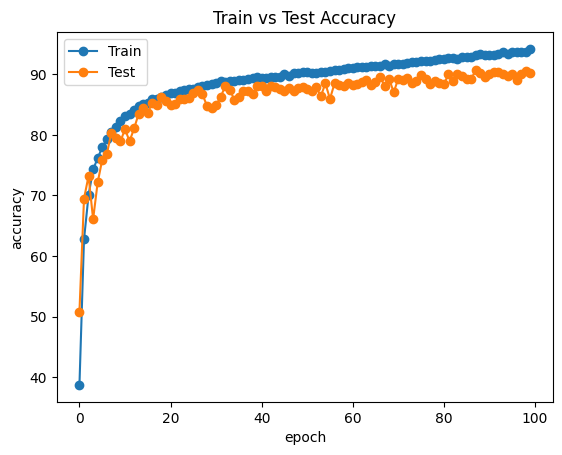

In [35]:
!pip install matplotlib
import matplotlib.pyplot as plt
plt.plot(tracc_list,'-o')
plt.plot(tacc_list,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Test'])
plt.title('Train vs Test Accuracy')
plt.show()

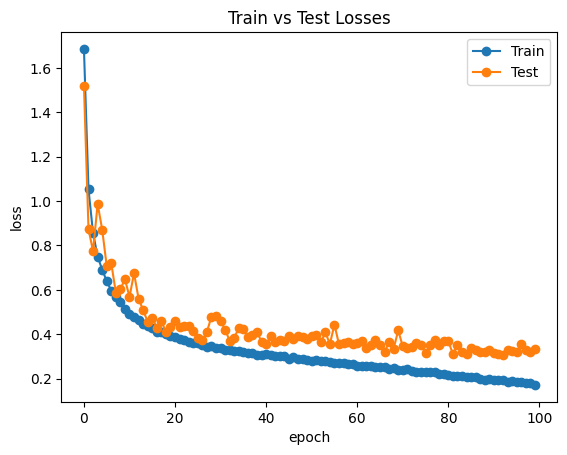

In [36]:
plt.plot(trloss_list,'-o')
plt.plot(tloss_list,'-o')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Test'])
plt.title('Train vs Test Losses')
plt.show()

In [ ]:
#for epoch in range(start_epoch, start_epoch+50):
    #train(epoch)
    #test(epoch)
    #scheduler.step()


Epoch: 0
Train Epoch: 0 | Loss: 0.239 | Acc: 89.844% (115/128)
Train Epoch: 0 | Loss: 0.233 | Acc: 90.625% (232/256)
Train Epoch: 0 | Loss: 0.217 | Acc: 91.406% (351/384)
Train Epoch: 0 | Loss: 0.220 | Acc: 91.211% (467/512)
Train Epoch: 0 | Loss: 0.213 | Acc: 91.719% (587/640)
Train Epoch: 0 | Loss: 0.200 | Acc: 92.448% (710/768)
Train Epoch: 0 | Loss: 0.210 | Acc: 92.299% (827/896)
Train Epoch: 0 | Loss: 0.201 | Acc: 92.578% (948/1024)
Train Epoch: 0 | Loss: 0.211 | Acc: 92.448% (1065/1152)
Train Epoch: 0 | Loss: 0.210 | Acc: 92.578% (1185/1280)
Train Epoch: 0 | Loss: 0.205 | Acc: 92.969% (1309/1408)
Train Epoch: 0 | Loss: 0.204 | Acc: 92.904% (1427/1536)
Train Epoch: 0 | Loss: 0.206 | Acc: 92.728% (1543/1664)
Train Epoch: 0 | Loss: 0.205 | Acc: 92.801% (1663/1792)
Train Epoch: 0 | Loss: 0.201 | Acc: 92.969% (1785/1920)
Train Epoch: 0 | Loss: 0.197 | Acc: 93.066% (1906/2048)
Train Epoch: 0 | Loss: 0.198 | Acc: 93.061% (2025/2176)
Train Epoch: 0 | Loss: 0.199 | Acc: 93.012% (2143/230

KeyboardInterrupt: 

In [ ]:
plt.plot(trloss_list,'-o')
plt.plot(tloss_list,'-o')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Test'])
plt.title('Train vs Test Losses')
plt.show()

In [ ]:
print(best_acc)

In [ ]:
!pip install matplotlib
import matplotlib.pyplot as plt
plt.plot(tracc_list,'-o')
plt.plot(tacc_list,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Test'])
plt.title('Train vs Test Accuracy')
plt.show()

In [ ]:
plt.plot(trloss_list,'-o')
plt.plot(tloss_list,'-o')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Test'])
plt.title('Train vs Test Losses')
plt.show()

In [15]:
for epoch in range(start_epoch, start_epoch+50):
    train(epoch)
    test(epoch)
    scheduler.step()

流式输出内容被截断，只能显示最后 5000 行内容。
Test Epoch: 39 | Loss: 0.321 | Acc: 90.667% (2992/3300)
Test Epoch: 39 | Loss: 0.322 | Acc: 90.588% (3080/3400)
Test Epoch: 39 | Loss: 0.323 | Acc: 90.571% (3170/3500)
Test Epoch: 39 | Loss: 0.323 | Acc: 90.639% (3263/3600)
Test Epoch: 39 | Loss: 0.327 | Acc: 90.595% (3352/3700)
Test Epoch: 39 | Loss: 0.329 | Acc: 90.526% (3440/3800)
Test Epoch: 39 | Loss: 0.327 | Acc: 90.615% (3534/3900)
Test Epoch: 39 | Loss: 0.327 | Acc: 90.700% (3628/4000)
Test Epoch: 39 | Loss: 0.330 | Acc: 90.585% (3714/4100)
Test Epoch: 39 | Loss: 0.332 | Acc: 90.548% (3803/4200)
Test Epoch: 39 | Loss: 0.330 | Acc: 90.651% (3898/4300)
Test Epoch: 39 | Loss: 0.326 | Acc: 90.750% (3993/4400)
Test Epoch: 39 | Loss: 0.322 | Acc: 90.822% (4087/4500)
Test Epoch: 39 | Loss: 0.323 | Acc: 90.739% (4174/4600)
Test Epoch: 39 | Loss: 0.323 | Acc: 90.723% (4264/4700)
Test Epoch: 39 | Loss: 0.326 | Acc: 90.646% (4351/4800)
Test Epoch: 39 | Loss: 0.324 | Acc: 90.714% (4445/4900)
Test Epoch: 39 | Loss

In [16]:
print(best_acc)

91.98


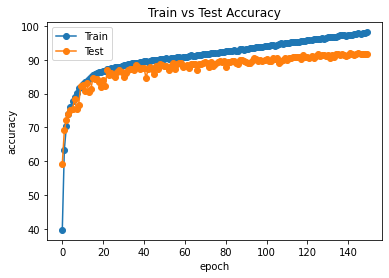

In [17]:
import matplotlib.pyplot as plt
plt.plot(tracc_list,'-o')
plt.plot(tacc_list,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Test'])
plt.title('Train vs Test Accuracy')
plt.show()

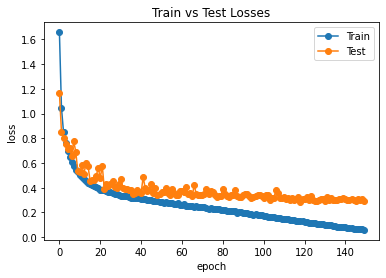

In [18]:
plt.plot(trloss_list,'-o')
plt.plot(tloss_list,'-o')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Test'])
plt.title('Train vs Test Losses')
plt.show()

In [19]:
net

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       